In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from matplotlib.pyplot import figure

# A3

# Generate Data
n = 30
X = np.random.uniform(0, 1, n)
epsilon = np.random.normal(0, 1, n)
x_plot = np.linspace(0, 1)
y = np.zeros(len(x_plot))
Y = np.zeros(n)
for i in range(n):
    Y[i] = 4 * np.sin(np.pi * X[i]) * np.cos(6 * np.pi * X[i]**2) + epsilon[i]
for i in range(len(x_plot)):
    y[i] = 4 * np.sin(np.pi * x_plot[i]) * np.cos(6 * np.pi * x_plot[i]**2)

In [37]:
# A3.a.1

def LOO_poly(lam, d):
    total_error = 0
    for j in range(n):
        X_copy = np.delete(X.copy(), j)
        Y_copy = np.delete(Y.copy(), j)
        # train on set without X[j]Y[j], get a F[j] (expected Y) for X[j]
        # poly
        K_poly = (np.outer(X_copy, X_copy) + 1) ** d
        alpha_poly = np.linalg.solve(K_poly + lam*np.eye(K_poly.shape[0]), Y_copy)
        predicted_j = alpha_poly.dot((1 + X_copy.dot(X[j]))**d)
        error = (Y[j] - predicted_j)**2
        total_error += error
    # error
    error_poly = total_error / n
    return error_poly

param_poly = None
lam_range = np.logspace(-8, -1, 50)
for lam in lam_range:
    for d in range(1, 15):
        error = LOO_poly(lam, d)
        if param_poly is None or error < param_poly[0]:
            param_poly = (error, lam, d)
print("Poly:", param_poly)

Poly: (5.05412374682622, 5.179474679231202e-06, 14)


In [38]:
lam = param_poly[1]
d = param_poly[2]
K = (np.outer(X, X) + 1) ** d
alpha = np.linalg.solve(K + lam*np.eye(K.shape[0]), Y)
y_plot = np.matmul((1 + np.outer(x_plot, X))**d, alpha)

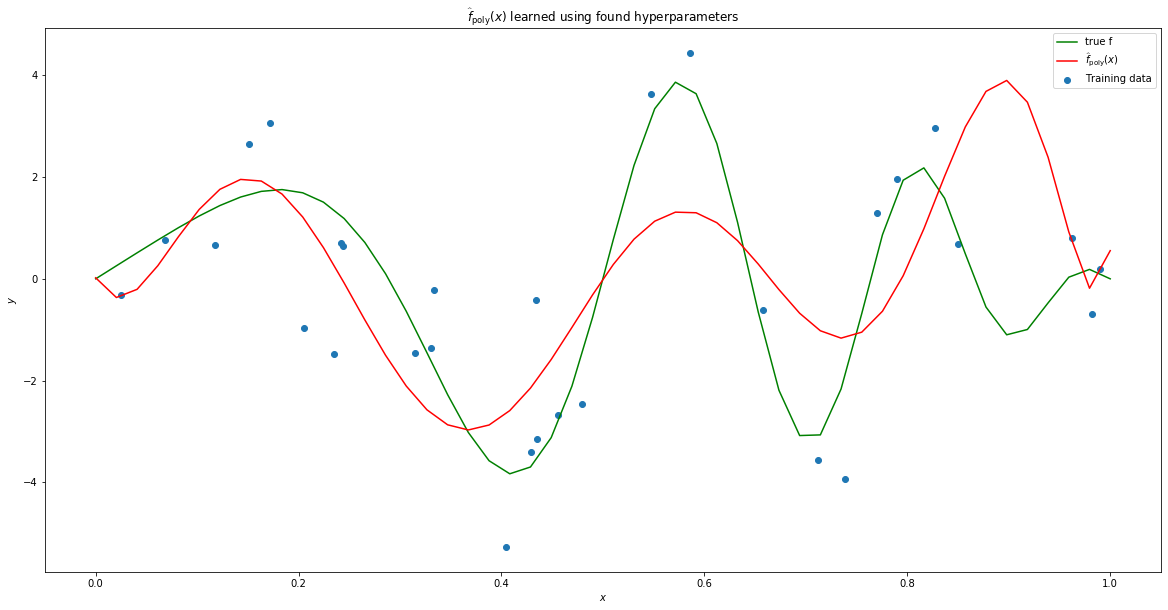

In [39]:
# A3.b 

# plotting poly
plt.figure(figsize=(20,10))
plt.scatter(X, Y, label='Training data') # original data
plt.plot(x_plot, y, 'g', label='true f') # true f
plt.plot(x_plot, y_plot, 'r', label='$\widehat{f}_\mathrm{poly}(x)$') # f_hat
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$\widehat{f}_\mathrm{poly}(x)$ learned using found hyperparameters')
plt.legend()

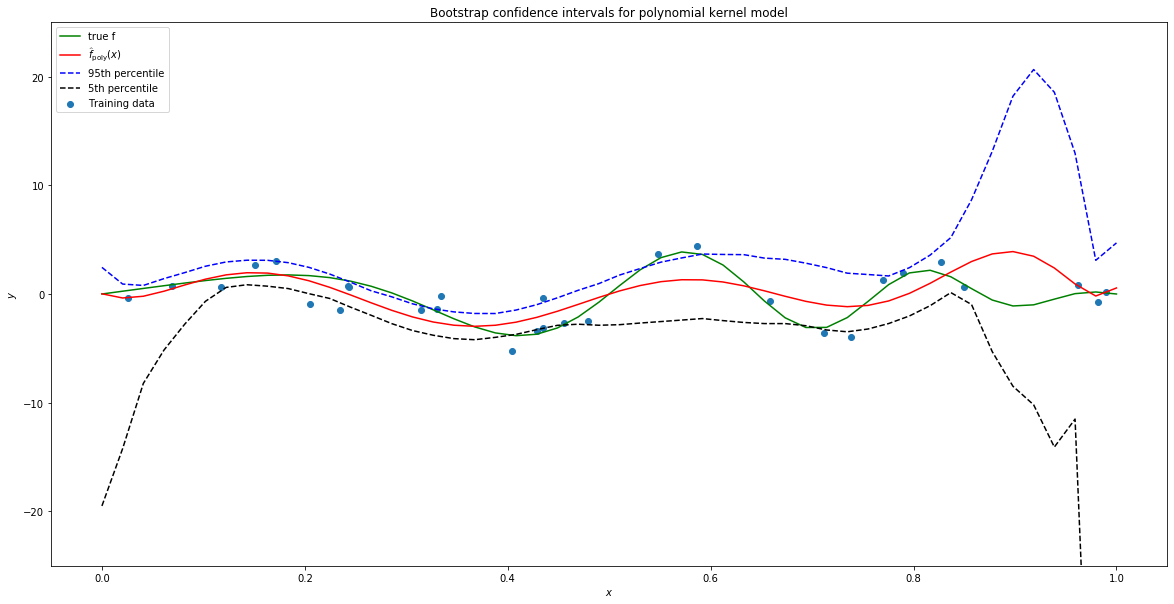

In [44]:
# A3.c Bootstrap
# poly kernel
B = 300
predictions = np.zeros((300, len(x_plot)))
for b in range(B):
    indices = np.random.choice(n, n, replace=True)
    training_set = []
    training_y = []
    for i in range(n):
        training_set.append(X[indices[i]])
        training_y.append(Y[indices[i]])
        
    lam = param_poly[1]
    d = param_poly[2]
    K = (np.outer(training_set, training_set) + 1) ** d
    alpha = np.linalg.solve(K + lam*np.eye(K.shape[0]), training_y)
    y_plot_boot = np.matmul((1 + np.outer(x_plot, training_set))**d, alpha)
    
    predictions[b] = y_plot_boot
    
sort_predict = np.zeros((300, len(x_plot)))
percentile_95 = np.zeros(len(x_plot))
percentile_5 = np.zeros(len(x_plot))
for i in range(len(x_plot)):
    sort_predict = np.sort(predictions[:, i])
    percentile_95[i] = sort_predict[int(B*0.95)]
    percentile_5[i] = sort_predict[int(B*0.05)]
    
plt.figure(figsize=(20,10))
plt.scatter(X, Y, label='Training data')
plt.plot(x_plot, y, 'g', label='true f')
plt.plot(x_plot, y_plot, 'r', label='$\widehat{f}_\mathrm{poly}(x)$')
plt.plot(x_plot, percentile_95, 'b--', label='95th percentile')
plt.plot(x_plot, percentile_5, 'k--', label='5th percentile')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Bootstrap confidence intervals for polynomial kernel model'.format(param_poly[1]))
plt.ylim((-25,25))
plt.legend()

In [45]:
# A3.a.2

def build_K(X, g):
    n = len(X)
    K = np.zeros((n, n))
    for i,a in enumerate(X):
        for j,b in enumerate(X):
            K[i,j] = np.exp(-g*np.linalg.norm(a-b)**2)
    return K

def LOO_rbf(lam, g, K):
    total_error = 0
    for j in range(n):
        X_copy, Y_copy = np.delete(X.copy(), j, axis=0), np.delete(Y.copy(), j)
        K_copy = np.delete(K.copy(), j, axis=0)
        K_copy = np.delete(K_copy, j, axis=1)
        alpha = np.linalg.solve(K_copy + lam*np.eye(K_copy.shape[0]), Y_copy)
        predicted = 0
        for i in range(len(X_copy)):
            predicted += alpha[i] * np.exp(-g*np.linalg.norm(X_copy[i]-X[j])**2)
            
        error = (Y[j] - predicted)**2
        total_error += error
    # error
    error = total_error / n
    return error
        

param_rbf = None
g_range = np.logspace(-3, 3, 50)
for lam in lam_range:
    for g in g_range:
        K = build_K(X, g)
        error = LOO_rbf(lam, g, K)
        if param_rbf is None or error < param_rbf[0]:
            param_rbf = (error, lam, g)
print("Rbf:", param_rbf)

Rbf: (2.172591416964767, 0.05179474679231202, 568.9866029018293)


In [46]:
lam = param_rbf[1]
g = param_rbf[2]
K = build_K(X, g)
alpha = np.linalg.solve(K + lam*np.eye(K.shape[0]), Y)
y_rbf = np.zeros(len(x_plot))
for i in range(len(alpha)):
    for j in range(len(x_plot)):
        y_rbf[j] += alpha[i] * np.exp(-g*np.linalg.norm(x_plot[j]-X[i])**2)

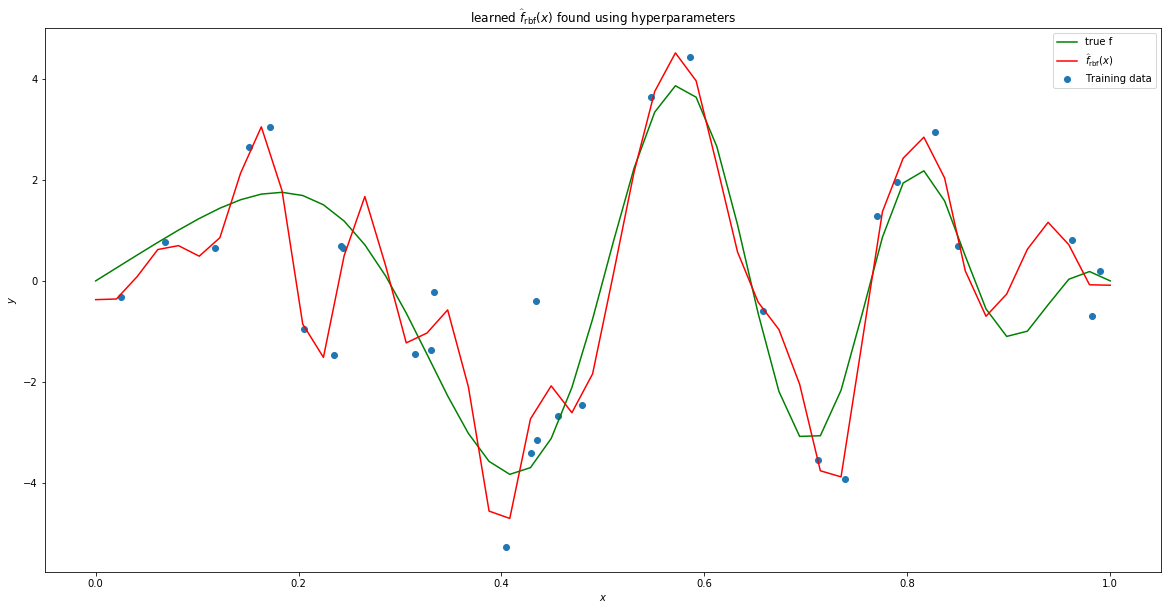

In [50]:
# plotting rbf
plt.figure(figsize=(20,10))
plt.scatter(X, Y, label='Training data') # original data
plt.plot(x_plot, y, 'g', label='true f') # true f
plt.plot(x_plot, y_rbf, 'r', label='$\widehat{f}_\mathrm{rbf}(x)$') # f_hat
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('learned $\widehat{f}_\mathrm{rbf}(x)$ found using hyperparameters')
plt.legend()

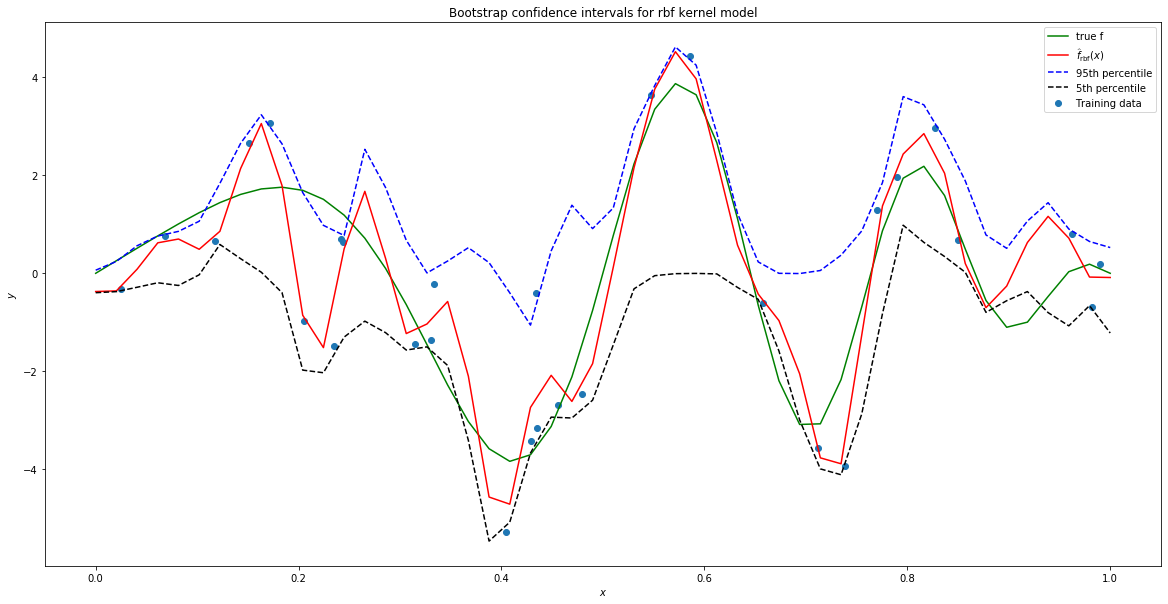

In [51]:
# rbf kernel bootstrap
B = 300
predictions = np.zeros((300, len(x_plot)))
for b in range(B):
    indices = np.random.choice(n, n, replace=True)
    training_set = []
    training_y = []
    for i in range(n):
        training_set.append(X[indices[i]])
        training_y.append(Y[indices[i]])
    
    lam = param_rbf[1]
    g = param_rbf[2]
    K = build_K(training_set, g)
    alpha = np.linalg.solve(K + lam*np.eye(K.shape[0]), training_y)
    y_rbf_boot = np.zeros(len(x_plot))
    for i in range(len(alpha)):
        for j in range(len(x_plot)):
            y_rbf_boot[j] += alpha[i] * np.exp(-g*np.linalg.norm(x_plot[j]-training_set[i])**2)   
    predictions[b] = y_rbf_boot
        
sort_predict = np.zeros((300, len(x_plot)))
percentile_95 = np.zeros(len(x_plot))
percentile_5 = np.zeros(len(x_plot))
for i in range(len(x_plot)):
    sort_predict = np.sort(predictions[:, i])
    percentile_95[i] = sort_predict[int(B*0.95)]
    percentile_5[i] = sort_predict[int(B*0.05)]
    
plt.figure(figsize=(20,10))
plt.scatter(X, Y, label='Training data')
plt.plot(x_plot, y, 'g', label='true f') # true f
plt.plot(x_plot, y_rbf, 'r', label='$\widehat{f}_\mathrm{rbf}(x)$')
plt.plot(x_plot, percentile_95, 'b--', label='95th percentile')
plt.plot(x_plot, percentile_5, 'k--', label='5th percentile')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Bootstrap confidence intervals for rbf kernel model'.format(param_rbf[1]))
plt.legend()

In [52]:
# A4
def Lloyds(X, k):
    n, d = X.shape
    # Randomly guess k cluster Center locations
    clusters = X[np.random.choice(n, k, replace=0)]
    error = []
    cont = True
    #iteration = 0
    while cont:
        centers = np.zeros((k,n)) # 0s and 1s, 1 if the nth point is owned by the kth center
        # Each datapoint finds out which Center it’s closest to
        for i in range(n):
            closest = None
            dist = 0
            index = None
            for j in range(k):
                temp_dist = X[i] - clusters[j]
                temp_dist = temp_dist.dot(temp_dist)
                if closest is None or temp_dist < dist:
                    closest = clusters[j]
                    dist = temp_dist
                    index = j
            centers[index, i] = 1
        # Each Center finds the centroid of the points it owns and jumps there
        cont = False
        for i in range(k):
            new_center = np.zeros(d)
            for j in range(n):
                if centers[i, j] == 1:
                    new_center += X[j]
            new_center /= centers[i].sum()
            if not np.array_equal(new_center, clusters[i]):
                cont = True
            clusters[i] = new_center
        total_error = 0
        for i in range(k):
            for j in range(n):
                if centers[i, j] == 1:
                    dist = X[j] - clusters[i]
                    total_error += dist.dot(dist)
        error.append(total_error)
    return clusters, error

In [53]:
from mnist import MNIST

mndata = MNIST('./data/')
X_train, labels_train = map(np.array, mndata.load_training()) 
X_test, labels_test = map(np.array, mndata.load_testing()) 
X_train = X_train/255.0
X_test = X_test/255.0

In [54]:
result = Lloyds(X_train, 10)

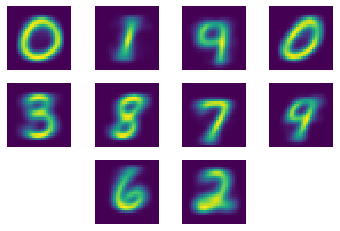

In [55]:
for i in range(10):
    plt.subplot(3, 4, i+2 if i >= 8 else i+1)
    plt.imshow(result[0][i].reshape(28, 28))
    plt.axis('off')

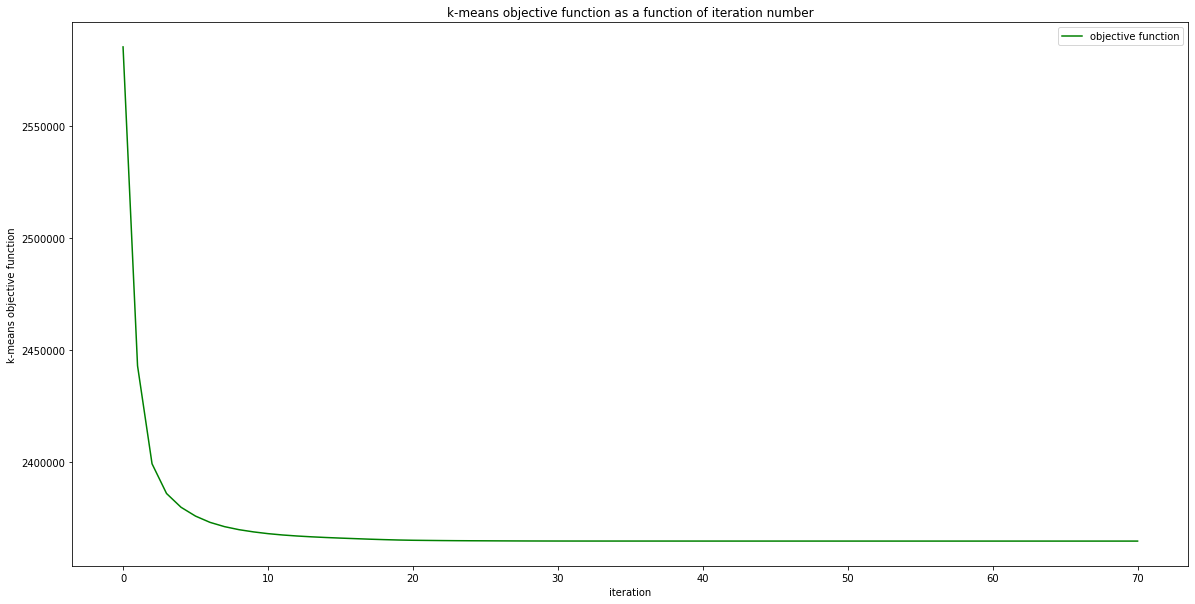

In [56]:
plt.figure(figsize=(20,10))
plt.xlabel('iteration')
plt.ylabel('k-means objective function')
plt.title('k-means objective function as a function of iteration number')
plt.plot(result[1], 'g', label='objective function')
plt.legend()

In [57]:
train = []
test = []
for k in [2, 4, 8, 16, 32, 64]:
    print(k)
    result = Lloyds(X_train, k)
    train_error = result[1][-1]
    test_error = 0
    for i in range(len(X_test)):
        closest = None
        dist = 0
        for j in range(k):
            temp_dist = X_test[i] - result[0][j]
            temp_dist = temp_dist.dot(temp_dist)
            if closest is None or temp_dist < dist:
                closest = result[0][j]
                dist = temp_dist
        test_error += dist
    train_error /= len(X_train)
    test_error /= len(X_test)
    train.append(train_error)
    test.append(test_error)

2
4
8
16
32
64


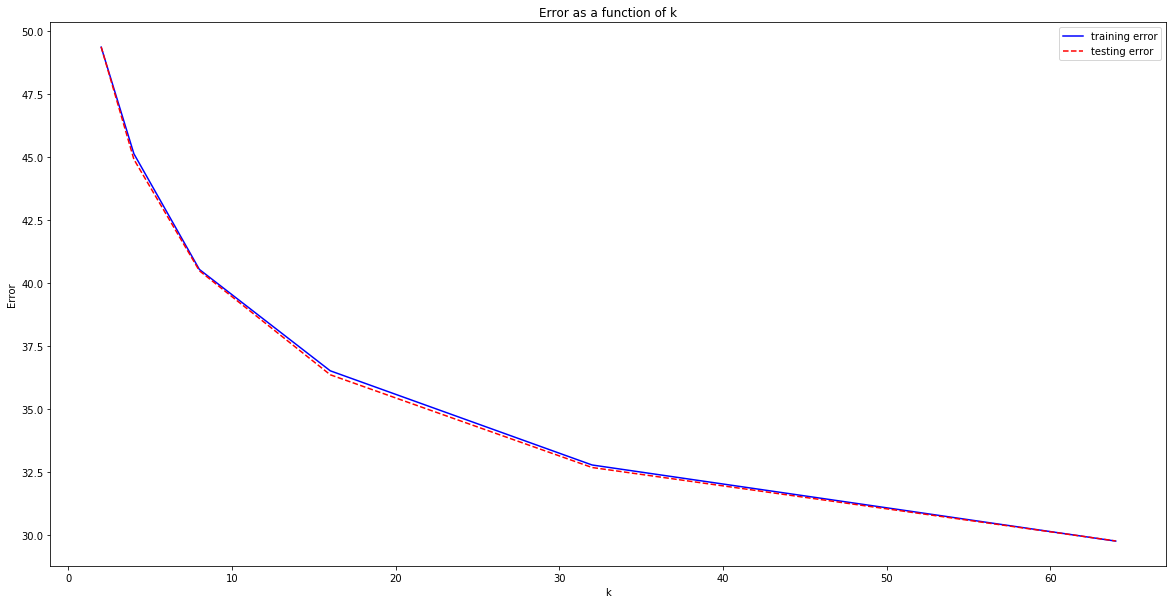

In [63]:
k = [2, 4, 8, 16, 32, 64]
plt.figure(figsize=(20, 10))
plt.plot(k, train, 'b', label="training error")
plt.plot(k, test, 'r--', label="testing error")
plt.title("Error as a function of k")
plt.xlabel("k")
plt.ylabel("Error")
plt.legend()